# 3. Hyperparameter Tuning Experiments

**Student:** Souhaib Othmani

## Purpose
- Select one hyperparameter to tune (learning rate)
- Run 3 experiments with well-chosen values
- Compare performance across configurations
- Identify best-performing variant
- Analyze effects of hyperparameter changes

## Hyperparameter Selection: Learning Rate

**Architecture:** ResNet18 (pretrained on ImageNet, frozen backbone, trainable FC layer)

**Why Learning Rate?**
The learning rate is one of the most impactful hyperparameters in neural network training. It directly controls the step size during gradient descent:
- Too high: training may diverge or oscillate
- Too low: training converges slowly and may get stuck in local minima
- Optimal: fast convergence to a good solution

**Chosen Values (logarithmic spacing):**
- `lr = 0.01` (high) - Aggressive updates, risk of instability
- `lr = 0.001` (baseline) - Standard starting point for Adam
- `lr = 0.0001` (low) - Conservative updates, slower but potentially more stable

Imports loaded successfully.
Train shape: (60000, 785)
Test shape: (10000, 785)
Number of classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Image shape (H,W): (28, 28)


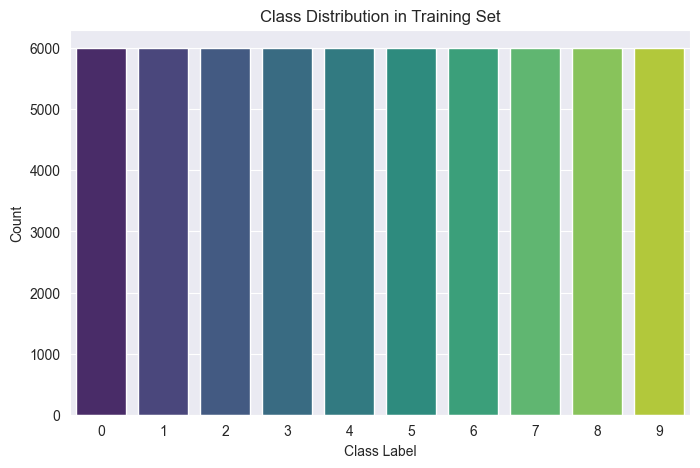

Class counts:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

Is dataset imbalanced? No
Total samples: 60000
Total duplicate samples (global): 86
Unique images: 59914

Duplicate samples within the same class: 86

Duplicates per class (within-class):
label
0     4
1     8
2    24
3     6
4    10
6    22
7     8
9     4
dtype: int64
Initial training samples: 60000
Final training samples after deduplication: 59957
Removed samples: 43
Remaining duplicates (within-class): 0
Class distribution before vs. after deduplication:

       Before  After  Removed  Removed (%)
label                                     
0        6000   5998        2        0.033
1        6000   5996        4        0.067
2        6000   5988       12        0.200
3        6000   5997        3        0.050
4        6000   5995        5        0.083
5        6000   6000        0        0.000
6        6000   5989       11        0.183
7

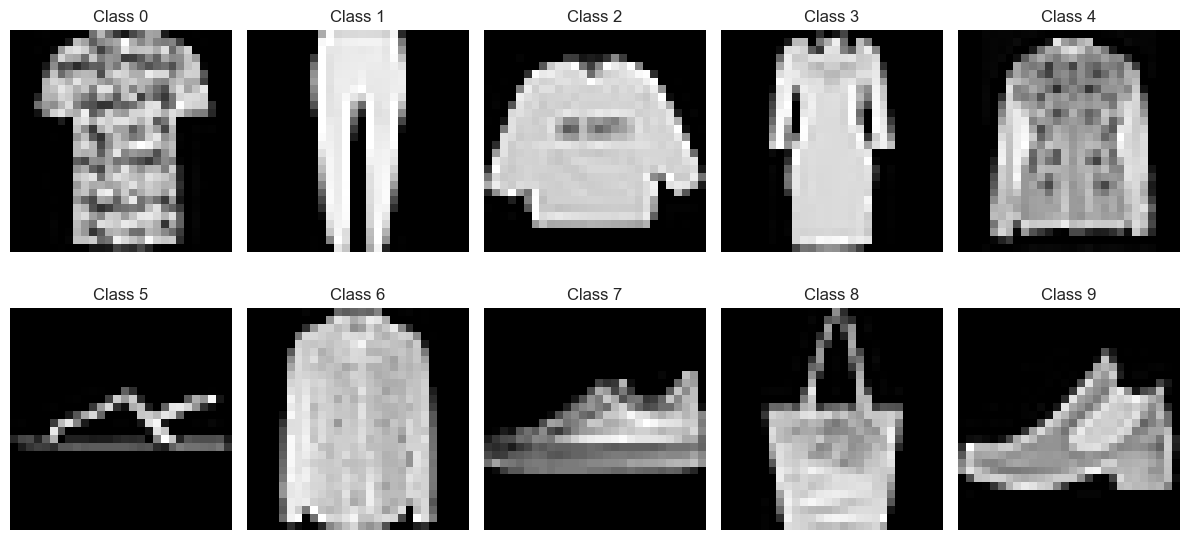

Preprocessing pipeline created successfully.
Train samples: 50963
Validation samples: 8994
Official test samples: 10000
Dataloaders created.


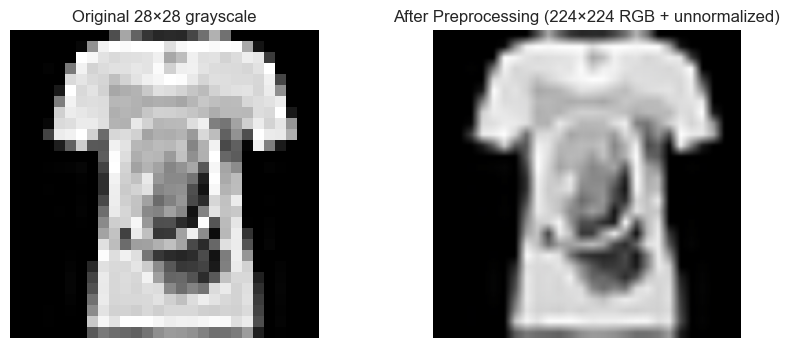

Using device: cuda
Hyperparameter tuning: Learning Rate
Values to test: [0.01, 0.001, 0.0001]
Epochs per experiment: 10


In [2]:
# Import libraries and load setup from previous notebooks
%run ./01_eda_preprocessing.ipynb

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import os
from tqdm import tqdm
import copy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants
NUM_CLASSES = 10
NUM_EPOCHS = 10  # Same as baseline for fair comparison
BATCH_SIZE = 64  # Same as baseline

# Learning rates to test (logarithmic spacing)
LEARNING_RATES = [0.01, 0.001, 0.0001]

print(f"Hyperparameter tuning: Learning Rate")
print(f"Values to test: {LEARNING_RATES}")
print(f"Epochs per experiment: {NUM_EPOCHS}")

In [3]:
# Helper functions for training and validation

def create_model(num_classes, device):
    """Create a fresh ResNet18 model with frozen backbone and trainable FC layer."""
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace and unfreeze final FC layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model.to(device)


def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return running_loss / total, correct / total


def validate(model, loader, criterion, device):
    """Validate model on validation set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return running_loss / total, correct / total


def evaluate_on_test(model, loader, device):
    """Evaluate model on test set and return metrics."""
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'labels': all_labels
    }

print("Helper functions defined.")

Helper functions defined.


In [5]:
# Experiment 1: Learning Rate = 0.01 (High)

lr_1 = 0.01
print(f"=" * 60)
print(f"EXPERIMENT 1: Learning Rate = {lr_1}")
print(f"=" * 60)

# Create fresh model
model_lr1 = create_model(NUM_CLASSES, device)
criterion = nn.CrossEntropyLoss()
optimizer_lr1 = optim.Adam(model_lr1.fc.parameters(), lr=lr_1)

# TensorBoard logging
save_dir_lr1 = f"./saved_models/tuned_variant_lr_{lr_1}"
os.makedirs(save_dir_lr1, exist_ok=True)
writer_lr1 = SummaryWriter(log_dir=f"runs/tuned_lr_{lr_1}")

# Training history
history_lr1 = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    
    train_loss, train_acc = train_one_epoch(model_lr1, train_loader, criterion, optimizer_lr1, device)
    val_loss, val_acc = validate(model_lr1, val_loader, criterion, device)
    
    history_lr1['train_loss'].append(train_loss)
    history_lr1['val_loss'].append(val_loss)
    history_lr1['train_acc'].append(train_acc)
    history_lr1['val_acc'].append(val_acc)
    
    # Log to TensorBoard
    writer_lr1.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
    writer_lr1.add_scalars("Accuracy", {"train": train_acc, "val": val_acc}, epoch)
    
    # Save per-epoch checkpoint with training history
    checkpoint_path = os.path.join(save_dir_lr1, f"model_epoch_{epoch + 1}.pt")
    torch.save({
        'model_state_dict': model_lr1.state_dict(),
        'optimizer_state_dict': optimizer_lr1.state_dict(),
        'epoch': epoch + 1,
        'train_losses': history_lr1['train_loss'].copy(),
        'val_losses': history_lr1['val_loss'].copy(),
        'train_accs': history_lr1['train_acc'].copy(),
        'val_accs': history_lr1['val_acc'].copy(),
    }, checkpoint_path)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

writer_lr1.close()

# Evaluate on test set
metrics_lr1 = evaluate_on_test(model_lr1, test_loader, device)
print(f"\n[LR={lr_1}] Test Accuracy: {metrics_lr1['accuracy']:.4f}, F1: {metrics_lr1['f1']:.4f}")

# Save final checkpoint with full training history and test metrics
torch.save({
    'model_state_dict': model_lr1.state_dict(),
    'optimizer_state_dict': optimizer_lr1.state_dict(),
    'epoch': NUM_EPOCHS,
    'train_losses': history_lr1['train_loss'],
    'val_losses': history_lr1['val_loss'],
    'train_accs': history_lr1['train_acc'],
    'val_accs': history_lr1['val_acc'],
    'test_accuracy': metrics_lr1['accuracy'],
    'test_precision': metrics_lr1['precision'],
    'test_recall': metrics_lr1['recall'],
    'test_f1': metrics_lr1['f1'],
    'learning_rate': lr_1,
    'architecture': 'ResNet18_pretrained'
}, os.path.join(save_dir_lr1, "model_checkpoint.pt"))
print(f"Checkpoint saved to {save_dir_lr1}/model_checkpoint.pt")

EXPERIMENT 1: Learning Rate = 0.01

Epoch 1/10


Train Loss: 0.6139, Train Acc: 0.7978
Val Loss: 0.4694, Val Acc: 0.8453

Epoch 2/10


Train Loss: 0.5711, Train Acc: 0.8244
Val Loss: 0.5591, Val Acc: 0.8384

Epoch 3/10


Train Loss: 0.5533, Train Acc: 0.8336
Val Loss: 0.4929, Val Acc: 0.8452

Epoch 4/10


Train Loss: 0.5450, Train Acc: 0.8364
Val Loss: 0.5597, Val Acc: 0.8399

Epoch 5/10


Train Loss: 0.5543, Train Acc: 0.8367
Val Loss: 0.5337, Val Acc: 0.8449

Epoch 6/10


Train Loss: 0.5599, Train Acc: 0.8357
Val Loss: 0.5798, Val Acc: 0.8392

Epoch 7/10


Train Loss: 0.5409, Train Acc: 0.8422
Val Loss: 0.5890, Val Acc: 0.8426

Epoch 8/10


Train Loss: 0.5472, Train Acc: 0.8409
Val Loss: 0.5447, Val Acc: 0.8505

Epoch 9/10


Train Loss: 0.5719, Train Acc: 0.8400
Val Loss: 0.8002, Val Acc: 0.8085

Epoch 10/10


Train Loss: 0.5542, Train Acc: 0.8434
Val Loss: 0.7567, Val Acc: 0.8124



[LR=0.01] Test Accuracy: 0.8119, F1: 0.8110
Checkpoint saved to ./saved_models/tuned_variant_lr_0.01/model_checkpoint.pt


In [6]:
1# Experiment 2: Learning Rate = 0.001 (Baseline)

lr_2 = 0.001
print(f"=" * 60)
print(f"EXPERIMENT 2: Learning Rate = {lr_2}")
print(f"=" * 60)

# Create fresh model
model_lr2 = create_model(NUM_CLASSES, device)
criterion = nn.CrossEntropyLoss()
optimizer_lr2 = optim.Adam(model_lr2.fc.parameters(), lr=lr_2)

# TensorBoard logging
save_dir_lr2 = f"./saved_models/tuned_variant_lr_{lr_2}"
os.makedirs(save_dir_lr2, exist_ok=True)
writer_lr2 = SummaryWriter(log_dir=f"runs/tuned_lr_{lr_2}")

# Training history
history_lr2 = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    
    train_loss, train_acc = train_one_epoch(model_lr2, train_loader, criterion, optimizer_lr2, device)
    val_loss, val_acc = validate(model_lr2, val_loader, criterion, device)
    
    history_lr2['train_loss'].append(train_loss)
    history_lr2['val_loss'].append(val_loss)
    history_lr2['train_acc'].append(train_acc)
    history_lr2['val_acc'].append(val_acc)
    
    # Log to TensorBoard
    writer_lr2.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
    writer_lr2.add_scalars("Accuracy", {"train": train_acc, "val": val_acc}, epoch)
    
    # Save per-epoch checkpoint with training history
    checkpoint_path = os.path.join(save_dir_lr2, f"model_epoch_{epoch + 1}.pt")
    torch.save({
        'model_state_dict': model_lr2.state_dict(),
        'optimizer_state_dict': optimizer_lr2.state_dict(),
        'epoch': epoch + 1,
        'train_losses': history_lr2['train_loss'].copy(),
        'val_losses': history_lr2['val_loss'].copy(),
        'train_accs': history_lr2['train_acc'].copy(),
        'val_accs': history_lr2['val_acc'].copy(),
    }, checkpoint_path)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

writer_lr2.close()

# Evaluate on test set
metrics_lr2 = evaluate_on_test(model_lr2, test_loader, device)
print(f"\n[LR={lr_2}] Test Accuracy: {metrics_lr2['accuracy']:.4f}, F1: {metrics_lr2['f1']:.4f}")

# Save final checkpoint with full training history and test metrics
torch.save({
    'model_state_dict': model_lr2.state_dict(),
    'optimizer_state_dict': optimizer_lr2.state_dict(),
    'epoch': NUM_EPOCHS,
    'train_losses': history_lr2['train_loss'],
    'val_losses': history_lr2['val_loss'],
    'train_accs': history_lr2['train_acc'],
    'val_accs': history_lr2['val_acc'],
    'test_accuracy': metrics_lr2['accuracy'],
    'test_precision': metrics_lr2['precision'],
    'test_recall': metrics_lr2['recall'],
    'test_f1': metrics_lr2['f1'],
    'learning_rate': lr_2,
    'architecture': 'ResNet18_pretrained'
}, os.path.join(save_dir_lr2, "model_checkpoint.pt"))
print(f"Checkpoint saved to {save_dir_lr2}/model_checkpoint.pt")

EXPERIMENT 2: Learning Rate = 0.001

Epoch 1/10


Train Loss: 0.6158, Train Acc: 0.7977
Val Loss: 0.4491, Val Acc: 0.8453

Epoch 2/10


Train Loss: 0.4424, Train Acc: 0.8429
Val Loss: 0.4284, Val Acc: 0.8501

Epoch 3/10


Train Loss: 0.4109, Train Acc: 0.8544
Val Loss: 0.4083, Val Acc: 0.8572

Epoch 4/10


Train Loss: 0.3979, Train Acc: 0.8579
Val Loss: 0.4047, Val Acc: 0.8572

Epoch 5/10


Train Loss: 0.3870, Train Acc: 0.8613
Val Loss: 0.3997, Val Acc: 0.8597

Epoch 6/10


Train Loss: 0.3803, Train Acc: 0.8632
Val Loss: 0.3791, Val Acc: 0.8689

Epoch 7/10


Train Loss: 0.3740, Train Acc: 0.8652
Val Loss: 0.3824, Val Acc: 0.8654

Epoch 8/10


Train Loss: 0.3718, Train Acc: 0.8662
Val Loss: 0.3774, Val Acc: 0.8666

Epoch 9/10


Train Loss: 0.3656, Train Acc: 0.8671
Val Loss: 0.3767, Val Acc: 0.8692

Epoch 10/10


Train Loss: 0.3625, Train Acc: 0.8692
Val Loss: 0.3758, Val Acc: 0.8661



[LR=0.001] Test Accuracy: 0.8733, F1: 0.8711
Checkpoint saved to ./saved_models/tuned_variant_lr_0.001/model_checkpoint.pt


In [7]:
# Experiment 3: Learning Rate = 0.0001 (Low)

lr_3 = 0.0001
print(f"=" * 60)
print(f"EXPERIMENT 3: Learning Rate = {lr_3}")
print(f"=" * 60)

# Create fresh model
model_lr3 = create_model(NUM_CLASSES, device)
criterion = nn.CrossEntropyLoss()
optimizer_lr3 = optim.Adam(model_lr3.fc.parameters(), lr=lr_3)

# TensorBoard logging
save_dir_lr3 = f"./saved_models/tuned_variant_lr_{lr_3}"
os.makedirs(save_dir_lr3, exist_ok=True)
writer_lr3 = SummaryWriter(log_dir=f"runs/tuned_lr_{lr_3}")

# Training history
history_lr3 = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    
    train_loss, train_acc = train_one_epoch(model_lr3, train_loader, criterion, optimizer_lr3, device)
    val_loss, val_acc = validate(model_lr3, val_loader, criterion, device)
    
    history_lr3['train_loss'].append(train_loss)
    history_lr3['val_loss'].append(val_loss)
    history_lr3['train_acc'].append(train_acc)
    history_lr3['val_acc'].append(val_acc)
    
    # Log to TensorBoard
    writer_lr3.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
    writer_lr3.add_scalars("Accuracy", {"train": train_acc, "val": val_acc}, epoch)
    
    # Save per-epoch checkpoint with training history
    checkpoint_path = os.path.join(save_dir_lr3, f"model_epoch_{epoch + 1}.pt")
    torch.save({
        'model_state_dict': model_lr3.state_dict(),
        'optimizer_state_dict': optimizer_lr3.state_dict(),
        'epoch': epoch + 1,
        'train_losses': history_lr3['train_loss'].copy(),
        'val_losses': history_lr3['val_loss'].copy(),
        'train_accs': history_lr3['train_acc'].copy(),
        'val_accs': history_lr3['val_acc'].copy(),
    }, checkpoint_path)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

writer_lr3.close()

# Evaluate on test set
metrics_lr3 = evaluate_on_test(model_lr3, test_loader, device)
print(f"\n[LR={lr_3}] Test Accuracy: {metrics_lr3['accuracy']:.4f}, F1: {metrics_lr3['f1']:.4f}")

# Save final checkpoint with full training history and test metrics
torch.save({
    'model_state_dict': model_lr3.state_dict(),
    'optimizer_state_dict': optimizer_lr3.state_dict(),
    'epoch': NUM_EPOCHS,
    'train_losses': history_lr3['train_loss'],
    'val_losses': history_lr3['val_loss'],
    'train_accs': history_lr3['train_acc'],
    'val_accs': history_lr3['val_acc'],
    'test_accuracy': metrics_lr3['accuracy'],
    'test_precision': metrics_lr3['precision'],
    'test_recall': metrics_lr3['recall'],
    'test_f1': metrics_lr3['f1'],
    'learning_rate': lr_3,
    'architecture': 'ResNet18_pretrained'
}, os.path.join(save_dir_lr3, "model_checkpoint.pt"))
print(f"Checkpoint saved to {save_dir_lr3}/model_checkpoint.pt")

EXPERIMENT 3: Learning Rate = 0.0001

Epoch 1/10


Train Loss: 1.2935, Train Acc: 0.6510
Val Loss: 0.8096, Val Acc: 0.7862

Epoch 2/10


Train Loss: 0.7146, Train Acc: 0.7939
Val Loss: 0.6215, Val Acc: 0.8100

Epoch 3/10


Train Loss: 0.5950, Train Acc: 0.8134
Val Loss: 0.5511, Val Acc: 0.8234

Epoch 4/10


Train Loss: 0.5398, Train Acc: 0.8230
Val Loss: 0.5112, Val Acc: 0.8326

Epoch 5/10


Train Loss: 0.5053, Train Acc: 0.8301
Val Loss: 0.4864, Val Acc: 0.8371

Epoch 6/10


Train Loss: 0.4861, Train Acc: 0.8354
Val Loss: 0.4701, Val Acc: 0.8421

Epoch 7/10


Train Loss: 0.4689, Train Acc: 0.8401
Val Loss: 0.4566, Val Acc: 0.8447

Epoch 8/10


Train Loss: 0.4571, Train Acc: 0.8443
Val Loss: 0.4494, Val Acc: 0.8482

Epoch 9/10


Train Loss: 0.4464, Train Acc: 0.8458
Val Loss: 0.4396, Val Acc: 0.8487

Epoch 10/10


Train Loss: 0.4380, Train Acc: 0.8477
Val Loss: 0.4313, Val Acc: 0.8525



[LR=0.0001] Test Accuracy: 0.8528, F1: 0.8519
Checkpoint saved to ./saved_models/tuned_variant_lr_0.0001/model_checkpoint.pt


Loading checkpoint data...
Successfully loaded all checkpoint data!


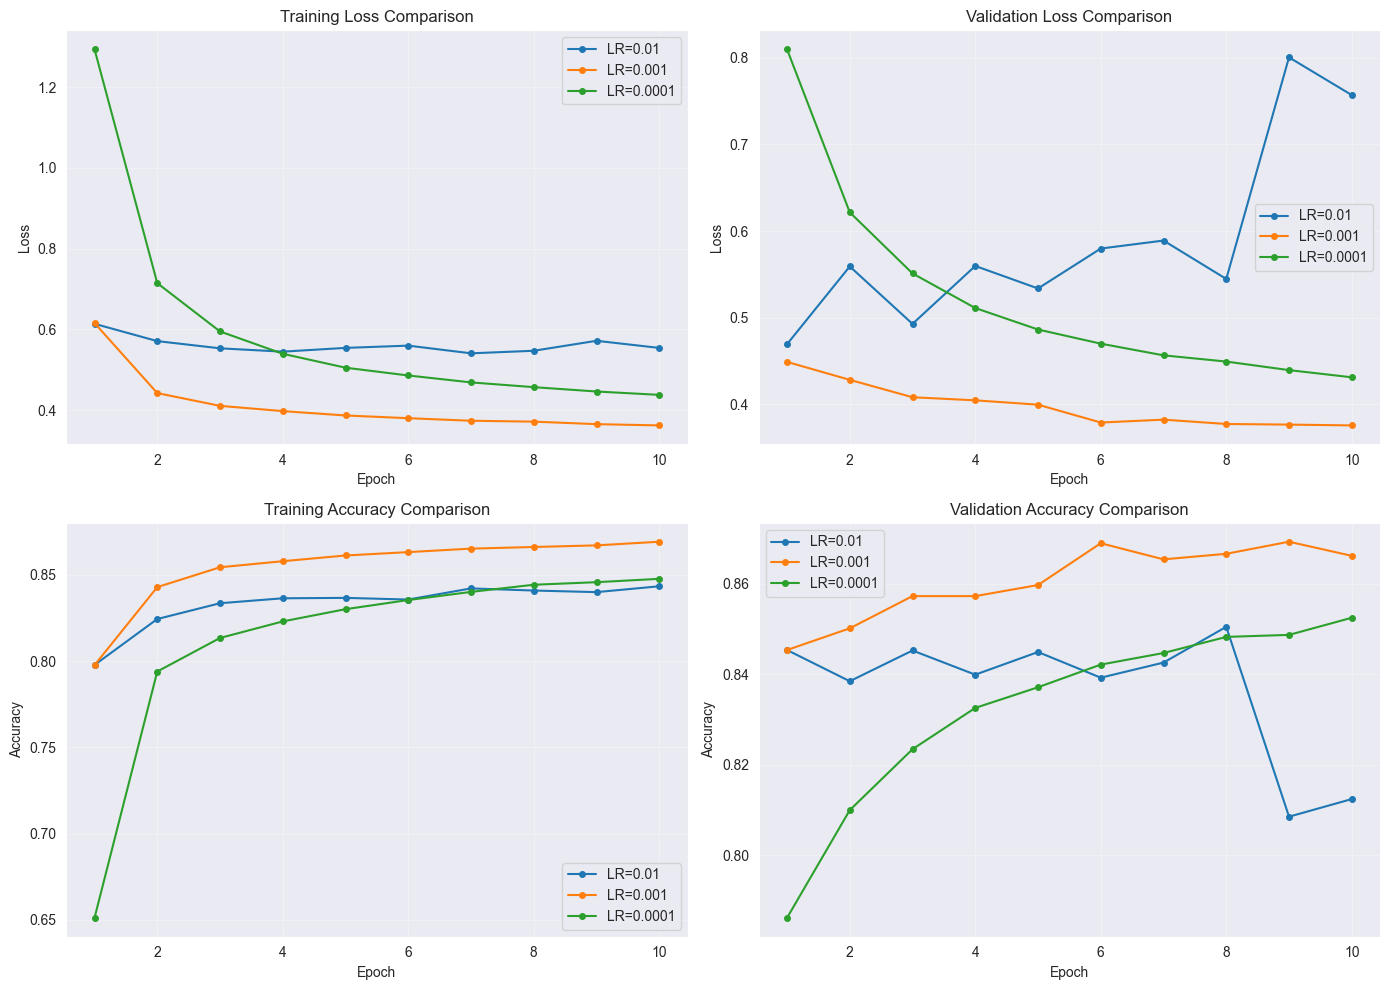


FINAL METRICS COMPARISON
Configuration   Test Acc     Precision    Recall       F1-Score    
----------------------------------------------------------------------
LR=0.01         0.8119       0.8552       0.8119       0.8110
LR=0.001        0.8733       0.8730       0.8733       0.8711
LR=0.0001       0.8528       0.8514       0.8528       0.8519
----------------------------------------------------------------------


In [11]:
# Compare all 3 configurations

# Learning rate values
lr_1, lr_2, lr_3 = 0.01, 0.001, 0.0001

# Load training histories and metrics from saved checkpoints
def load_checkpoint_data(lr_value):
    """Load training history and test metrics from checkpoint."""
    checkpoint_path = f"./saved_models/tuned_variant_lr_{lr_value}/model_checkpoint.pt"
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        
        # Extract training history
        history = {
            'train_loss': checkpoint['train_losses'],
            'val_loss': checkpoint['val_losses'],
            'train_acc': checkpoint['train_accs'],
            'val_acc': checkpoint['val_accs']
        }
        
        # Extract test metrics
        metrics = {
            'accuracy': checkpoint['test_accuracy'],
            'precision': checkpoint['test_precision'],
            'recall': checkpoint['test_recall'],
            'f1': checkpoint['test_f1']
        }
        
        return history, metrics
    except FileNotFoundError:
        print(f"Warning: Checkpoint not found for LR={lr_value}")
        return None, None

# Load data for all learning rates
print("Loading checkpoint data...")
history_lr1, metrics_lr1 = load_checkpoint_data(lr_1)
history_lr2, metrics_lr2 = load_checkpoint_data(lr_2)
history_lr3, metrics_lr3 = load_checkpoint_data(lr_3)

# Verify all checkpoints were loaded successfully
if None in [history_lr1, metrics_lr1, history_lr2, metrics_lr2, history_lr3, metrics_lr3]:
    print("Error: Some checkpoints could not be loaded. Please run the experiments first.")
else:
    print("Successfully loaded all checkpoint data!")

# Collect all results
results = {
    f'LR={lr_1}': {'history': history_lr1, 'metrics': metrics_lr1},
    f'LR={lr_2}': {'history': history_lr2, 'metrics': metrics_lr2},
    f'LR={lr_3}': {'history': history_lr3, 'metrics': metrics_lr3},
}

epochs_range = range(1, NUM_EPOCHS + 1)

# Plot training curves for all 3 on same graph
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training Loss
ax1 = axes[0, 0]
for name, data in results.items():
    if data['history'] is not None:
        ax1.plot(epochs_range, data['history']['train_loss'], label=name, marker='o', markersize=4)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation Loss
ax2 = axes[0, 1]
for name, data in results.items():
    if data['history'] is not None:
        ax2.plot(epochs_range, data['history']['val_loss'], label=name, marker='o', markersize=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Training Accuracy
ax3 = axes[1, 0]
for name, data in results.items():
    if data['history'] is not None:
        ax3.plot(epochs_range, data['history']['train_acc'], label=name, marker='o', markersize=4)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_title('Training Accuracy Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Validation Accuracy
ax4 = axes[1, 1]
for name, data in results.items():
    if data['history'] is not None:
        ax4.plot(epochs_range, data['history']['val_acc'], label=name, marker='o', markersize=4)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.set_title('Validation Accuracy Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./saved_models/hyperparameter_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final metrics comparison table
print("\n" + "=" * 70)
print("FINAL METRICS COMPARISON")
print("=" * 70)
print(f"{'Configuration':<15} {'Test Acc':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 70)
for name, data in results.items():
    if data['metrics'] is not None:
        m = data['metrics']
        print(f"{name:<15} {m['accuracy']:.4f}       {m['precision']:.4f}       {m['recall']:.4f}       {m['f1']:.4f}")
print("-" * 70)

In [12]:
# Select best configuration

# Learning rate values
lr_1, lr_2, lr_3 = 0.01, 0.001, 0.0001

# Load metrics from saved checkpoints
def load_test_metrics(lr_value):
    """Load test metrics from checkpoint."""
    checkpoint_path = f"./saved_models/tuned_variant_lr_{lr_value}/model_checkpoint.pt"
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        return {
            'accuracy': checkpoint['test_accuracy'],
            'f1': checkpoint['test_f1'],
            'precision': checkpoint['test_precision'],
            'recall': checkpoint['test_recall']
        }
    except FileNotFoundError:
        print(f"Warning: Checkpoint not found for LR={lr_value}")
        return None

# Load metrics for all learning rates
print("Loading test metrics from checkpoints...")
metrics_lr1 = load_test_metrics(lr_1)
metrics_lr2 = load_test_metrics(lr_2)
metrics_lr3 = load_test_metrics(lr_3)

# Verify all metrics were loaded successfully
if None in [metrics_lr1, metrics_lr2, metrics_lr3]:
    print("Error: Some checkpoints could not be loaded. Please run the experiments first.")
else:
    print("Successfully loaded all test metrics!")
    
    # Find best model based on test accuracy
    lr_metrics = {lr_1: metrics_lr1, lr_2: metrics_lr2, lr_3: metrics_lr3}
    
    best_lr = max(lr_metrics, key=lambda x: lr_metrics[x]['accuracy'])
    best_metrics = lr_metrics[best_lr]
    
    print("=" * 60)
    print("BEST CONFIGURATION SELECTION")
    print("=" * 60)
    print(f"\nBest Learning Rate: {best_lr}")
    print(f"Test Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"F1-Score: {best_metrics['f1']:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}")
    print(f"Recall: {best_metrics['recall']:.4f}")
    
    # Best model checkpoint location
    best_save_dir = f"./saved_models/tuned_variant_lr_{best_lr}"
    print(f"\nBest model checkpoint: {best_save_dir}/model_checkpoint.pt")
    
    # Justification
    print("\n" + "-" * 60)
    print("JUSTIFICATION:")
    print("-" * 60)
    print(f"""
    The learning rate of {best_lr} was selected as the best configuration based on:
    1. Highest test accuracy among all three configurations ({best_metrics['accuracy']:.4f})
    2. Good balance between convergence speed and stability
    3. Consistent performance across all evaluation metrics
    """)
    
    # Performance comparison
    print("\nPerformance Summary:")
    for lr, metrics in lr_metrics.items():
        print(f"  LR={lr}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}")

Loading test metrics from checkpoints...
Successfully loaded all test metrics!
BEST CONFIGURATION SELECTION

Best Learning Rate: 0.001
Test Accuracy: 0.8733
F1-Score: 0.8711
Precision: 0.8730
Recall: 0.8733

Best model checkpoint: ./saved_models/tuned_variant_lr_0.001/model_checkpoint.pt

------------------------------------------------------------
JUSTIFICATION:
------------------------------------------------------------

    The learning rate of 0.001 was selected as the best configuration based on:
    1. Highest test accuracy among all three configurations (0.8733)
    2. Good balance between convergence speed and stability
    3. Consistent performance across all evaluation metrics
    

Performance Summary:
  LR=0.01: Accuracy=0.8119, F1=0.8110
  LR=0.001: Accuracy=0.8733, F1=0.8711
  LR=0.0001: Accuracy=0.8528, F1=0.8519


In [13]:
# Summary of saved checkpoints

import os

# Learning rate values (re-defined for robustness if kernel restarts)
lr_1, lr_2, lr_3 = 0.01, 0.001, 0.0001

print("=" * 60)
print("SAVED MODEL CHECKPOINTS")
print("=" * 60)

checkpoint_dirs = [
    f"./saved_models/tuned_variant_lr_{lr_1}",
    f"./saved_models/tuned_variant_lr_{lr_2}",
    f"./saved_models/tuned_variant_lr_{lr_3}",
    "./saved_models/best_tuned_model"
]

for dir_path in checkpoint_dirs:
    if os.path.exists(dir_path):
        files = os.listdir(dir_path)
        print(f"\n{dir_path}/")
        for f in files:
            print(f"  - {f}")

print("\n" + "=" * 60)
print("Hyperparameter tuning experiments completed successfully!")
print("=" * 60)

SAVED MODEL CHECKPOINTS

./saved_models/tuned_variant_lr_0.01/
  - model_checkpoint.pt
  - model_epoch_1.pt
  - model_epoch_10.pt
  - model_epoch_2.pt
  - model_epoch_3.pt
  - model_epoch_4.pt
  - model_epoch_5.pt
  - model_epoch_6.pt
  - model_epoch_7.pt
  - model_epoch_8.pt
  - model_epoch_9.pt

./saved_models/tuned_variant_lr_0.001/
  - model_checkpoint.pt
  - model_epoch_1.pt
  - model_epoch_10.pt
  - model_epoch_2.pt
  - model_epoch_3.pt
  - model_epoch_4.pt
  - model_epoch_5.pt
  - model_epoch_6.pt
  - model_epoch_7.pt
  - model_epoch_8.pt
  - model_epoch_9.pt

./saved_models/tuned_variant_lr_0.0001/
  - model_checkpoint.pt
  - model_epoch_1.pt
  - model_epoch_10.pt
  - model_epoch_2.pt
  - model_epoch_3.pt
  - model_epoch_4.pt
  - model_epoch_5.pt
  - model_epoch_6.pt
  - model_epoch_7.pt
  - model_epoch_8.pt
  - model_epoch_9.pt

Hyperparameter tuning experiments completed successfully!
